In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Classifying Digits with Convolutional Neural Net (CNN)

### Read Data
The **batch size** is the number of samples passed through the neural net at a time. So if there are 1,000 samples and your batch size is 100 then for each epoch there will be 1,000/100 = 10 batches passed through the net. An advantage is if you have one billion samples and you don't have the computing power (memory) to pass it all at once. Also it's been shown that networks train faster using batches smaller than the entire sample.

The data is downloaded from pytorch module and stored in the root file. The pytorch class DataLoader is used to load the data set into the environment. Typically we would like to normalize the data and the transform argument in DataLoader class is a nice place to pass a Compose class that contains both the ToTensor conversion as well as Normalize function. In this case we'll just do the ToTensor conversion and calculate the mean and std dev in a moment which can be used in the future.

In [2]:
batch_size_train = 100
train_mnist = torchvision.datasets.MNIST('C:/projects/summer2020/vision/digits/', train=True, download=True,
                        transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_mnist, batch_size=batch_size_train, shuffle=True)

In [3]:
batch_size_test = 1000
test_mnist = torchvision.datasets.MNIST('C:/projects/summer2020/vision/digits/', train=False, download=True,
                        transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_mnist,batch_size=batch_size_test, shuffle=True)

### Structure of data
The data train_loader and test_loader are pytorch DataLoader classes. The train data set has 60,000 images while the test set has 10,000. The structure of the object train_loader is of length n_images/batch_size = 60,000/100 = 600. Then we'll plot one of the digits.

In [4]:
len(train_loader)

600

In [5]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

([], <a list of 0 Text yticklabel objects>)

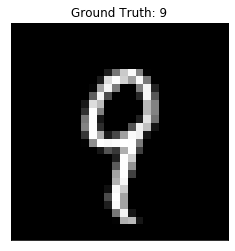

In [6]:
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[0]))
plt.xticks([])
plt.yticks([])

### Construct the neural net
It's typical to create a neural network as an object to hold the structure of the model. We'll step through each line in the constructor and the 'forward' class method.

Constructor:
- self.conv1: The first layer. It takes 1 channel in (the image) and returns 10 channels. The kernel size is 5x5.
- self.conv2: The second layer. It takes 10 channels in (from layer one) and returns 20 channels. Also kernel size of 5x5.
- self.conv2_drop: 
- self.fc1:
- self.fc2:

'forward' method:


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

This is a good place to explain what the parameters of training the neural network are. 

The most important is the **learning rate**. When using gradient decent to optimize a function the learning rate is the rate at which the weights improve. I love the example of trying to find the bottom of a valley. If you take a huge step then you might overstep the lowest point. Whereas if you take baby steps then you might find it but it will take a while and it will be more difficult to determine the gradient with such small steps. You are looking for a sweet spot where you make significant progress while not missing the optimal values. 

In [8]:
n_epochs = 2
learning_rate = 0.005
log_interval = 20

In [9]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))


In [12]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [13]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\scott\Anaconda3\envs\general-vision\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\scott\Anaconda3\envs\general-vision\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3044, Accuracy: 1135/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311195
Train Epoch: 1 [2000/60000 (3%)]	Loss: 1.570896
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.767959
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.759832
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.614130
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.604069
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.590549
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.576441
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.291166
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.351497
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.266274
Train Epoch: 1 [22000/60000 (37%)]	Loss: 0.274054
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.313785
Train Epoch: 1 [26000/60000 (43%)]	Loss: 0.393015
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.456295
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.327399
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.557635
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.408605
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.326318
Tra

Text(0, 0.5, 'negative log likelihood loss')

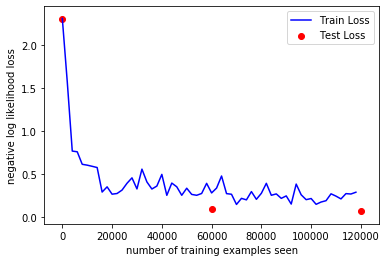

In [14]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [15]:
with torch.no_grad():
  prediction = network(example_data)

C:\Users\scott\Anaconda3\envs\general-vision\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


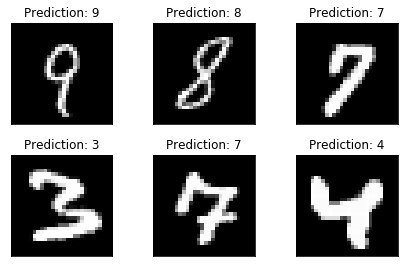

In [16]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(prediction.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])